In [23]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [25]:
county_shapes = pd.read_csv("./ny_county_shapes.csv").set_index("county_name")

In [26]:
len(county_shapes)

62

In [27]:
county_shapes.columns

Index(['min_lng_rank', 'min_lat_rank', 'max_lng_rank', 'max_lat_rank',
       'num_squares', 'county', 'ttl', 'pre_mult', 'mult', 'sqrt_mult',
       'mid_lng_rank', 'mid_lat_rank', 'lat_rank_range', 'scaled_min_lat_rank',
       'scaled_max_lat_rank', 'lng_rank_range', 'scaled_min_lng_rank',
       'scaled_max_lng_rank'],
      dtype='object')

In [28]:
for i in ["lat", "lng"]:
    county_shapes["new_mid_{}_rank".format(i)] = county_shapes["mid_{}_rank".format(i)]

In [29]:
def rev_pair(l):
    return [l, l[::-1]]

def check_intersect(row):
    return (min(
        [row["scaled_min_{}_rank_{}".format(i, j[0])] <= row["scaled_max_{}_rank_{}".format(i, j[1])]
        for i in ["lng", "lat"] for j in rev_pair(["x", "y"])]))

def dist(x1, y1, x2, y2):
    return np.sqrt(np.power(x1 - x2, 2) + np.power(y1 - y2, 2))

def move(x1, y1, x2, y2, move_dist):
    d = dist(x1, x2, y1, y2)
    dist_ratio = 1.0 * (d + move_dist) / d
    new_x1 = x2 + dist_ratio * (x1 - x2)
    new_y1 = y2 + dist_ratio * (y1 - y2)
    new_x2 = x1 + dist_ratio * (x2 - x1)
    new_y2 = y1 + dist_ratio * (y2 - y1)
    return new_x1, new_y1, new_x2, new_y2

def move_row(row, move_dist):
    return move(*([row["new_mid_{}_rank_{}".format(i, j)] for j in ["x", "y"] for i in ["lat", "lng"]] + [move_dist]))



def untangle(county_shapes, move_dist):
    county_shapes["dummy"] = 1
    county_shapes_join = county_shapes.merge(right = county_shapes, on = "dummy", how = "left")
    county_shapes_join_diff = county_shapes_join[~(county_shapes_join.county_x == county_shapes_join.county_y)]
    
    rand_row = county_shapes_join_diff.sample().iloc[0]
    if check_intersect(rand_row):
        # print("intersects: {} and {}".format(rand_row["county_x"], rand_row["county_y"]))
        new_centers = move_row(rand_row, move_dist)
        
        # move the smaller county
        # if rand_row["mult_x"] > rand_row["mult_y"]:
        #     s = 1
        #     i = "y"
        # else:
        #     s = 0
        #     i = "x"
        for s, i in enumerate(["x", "y"]):
            for t, j in enumerate(["lat", "lng"]):
                old_value = county_shapes.at[rand_row["county_{}".format(i)], "new_mid_{}_rank".format(j)]
                new_value = new_centers[2 * s + t]
                # print("old: {} new: {}".format(old_value, new_value))
                county_name = rand_row["county_{}".format(i)]
                county_shapes.at[county_name, "new_mid_{}_rank".format(j)] = new_centers[2 * s + t]

                # update mins and maxes
                for u, k in enumerate(["min", "max"]):
                    county_shapes.at[county_name, "scaled_{}_{}_rank".format(k, j)] = (
                        county_shapes.at[county_name, "new_mid_{}_rank".format(j)] +
                        ((2 * u - 1) * county_shapes.at[county_name, "sqrt_mult"] *
                        county_shapes.at[county_name, "{}_rank_range".format(j)] / 2))
        return [rand_row["county_x"], rand_row["county_y"]]
    else:
        return ["", ""]

In [30]:
untangles = []
for i in tqdm(range(200000)):
    untangles.append(untangle(county_shapes, 1) + [i + 1])

100%|██████████| 200000/200000 [27:17<00:00, 122.11it/s]


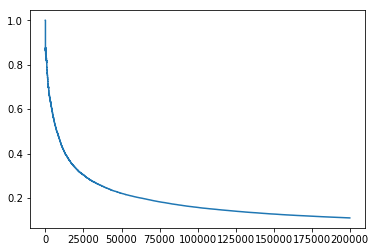

In [31]:
untangles_df = pd.DataFrame(untangles, columns = ["county_x", "county_y", "iteration"])
untangles_df["intersect"] = untangles_df.county_x.map(lambda x: not x == "")
untangles_df["num_inter"] = untangles_df.intersect.cumsum()
untangles_df["pcnt_inter"] = untangles_df.num_inter / untangles_df.iteration
untangles_df.pcnt_inter.plot()

In [32]:
orig_county_shapes = pd.read_csv("./ny_county_shapes.csv").set_index("county_name")

In [33]:
cols = ["scaled_{}_{}_rank".format(i, j) for i in ["min", "max"] for j in ["lat", "lng"]] + ["mid_{}_rank".format(j) for j in ["lat", "lng"]]

In [34]:
orig_county_shapes[cols].head()

,scaled_min_lat_rank,scaled_min_lng_rank,scaled_max_lat_rank,scaled_max_lng_rank,mid_lat_rank,mid_lng_rank
county_name,,,,,,
Albany,-24.308027,7.493311,99.308027,110.506689,37.5,59.0
Allegany,17.477854,9.818570,46.522146,29.181430,32.0,19.5
Bronx,-146.523147,-17.011574,161.523147,137.011574,7.5,60.0
Broome,-6.285955,3.714045,68.285955,78.285955,31.0,41.0
Cattaraugus,16.060458,-1.668482,47.939542,26.668482,32.0,12.5


In [35]:
county_shapes[cols].head()

,scaled_min_lat_rank,scaled_min_lng_rank,scaled_max_lat_rank,scaled_max_lng_rank,mid_lat_rank,mid_lng_rank
county_name,,,,,,
Albany,67.272127,169.695532,190.888180,272.708909,37.5,59.0
Allegany,-0.827753,-19.972782,28.216538,-0.609921,32.0,19.5
Bronx,-405.078127,45.988583,-97.031832,200.011730,7.5,60.0
Broome,-74.919066,-30.505350,-0.347156,44.066560,31.0,41.0
Cattaraugus,8.440689,-55.602629,40.319773,-27.265665,32.0,12.5


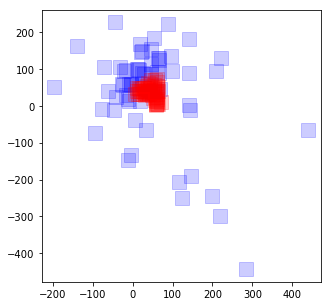

In [36]:
fig, ax = plt.subplots(figsize = (5, 5))
ax.scatter(x = county_shapes.new_mid_lng_rank, y = county_shapes.new_mid_lat_rank, c = "blue", marker = "s", s = 200, alpha = 0.2)
ax.scatter(x = orig_county_shapes.mid_lng_rank, y = orig_county_shapes.mid_lat_rank, c = "red", marker = "s", s = 200, alpha = 0.2)

In [37]:
county_shapes.to_csv("./ny_new_county_shapes.csv", index = False)